In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

%config IPCompleter.greedy=True

In [182]:
class ES:
    def __init__(self, eval_f, population_size, chromosome_len=20, K=0.9, tau0=None, tau1=None):
        '''
        Args:
            population_size : int
                Number of cars in the population
            chromosome_len : int
                Length of the list, which is our answer for the problem
            K : int
                Kind of learning rate parameter
        '''

        self.eval_f = eval_f
        self.population_size: int = population_size
        self.d: int = chromosome_len
        self.K: float = K
        self.tau0: float = tau0
        self.tau1: float = tau1

        if self.tau0 is None:
            self.tau0 = K / np.sqrt(2 * np.sqrt(self.d))

        if self.tau1 is None:
            self.tau1 = K / np.sqrt(2 * self.d)

        self.population_angles = np.random.uniform(
            low=-15,
            high=16,
            size=(self.population_size, self.d)
        )
        # 1 - increase thrust | 0 - nothing | -1 - decrease thrust
        self.population_thrust = np.random.randint(
            low=-1,
            high=2,
            size=(self.population_size, self.d)
        )
        
        self.population = np.stack((self.population_angles, self.population_thrust), axis=2)
        
        self.sigmas = np.random.uniform(
            low=0,
            high=1,
            size=(self.population_size, self.d, 2)
        )

        self.cost = self.eval_f(self.population)
        self.cost_history = []  # List[Tuple[min, mean, max]]
        self.population_history = []  # List[np.ndarray]
        self.sigmas_history = []  # List[np.ndarray]
        self.best_individuals = []  # List[Tuple[np.ndarray, fitness]]

    def parents_selection(self) -> np.ndarray:
        fitness_values = self.cost
        fitness_values = fitness_values - fitness_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(len(self.population)) / len(self.population)

        ids = np.random.choice(
            np.arange(self.population_size),
            size=self.population_size,
            replace=True,
            p=fitness_values
        )
        return ids

    
    def crossover(self, ids) -> None:
        self.population = self.population[ids]

        
    def mutation(self) -> None:
        ''' ES algorithm based mutation '''
        X = self.population
        Sigmas = self.sigmas

        E = np.random.normal(0, self.tau1, size=Sigmas.shape)
        eps_o = np.random.normal(0, self.tau0)
        Sigmas *= np.exp(E + eps_o)

        self.population = X + np.random.normal(0, 1, size=Sigmas.shape) * Sigmas
        assert (self.sigmas == Sigmas).all()

    
    def run(self, iters: int) -> None:
        for i in tqdm(range(iters), desc='ES(µ + λ)', position=0, leave=True):
            parents_ids = self.parents_selection()
            self.crossover(ids=parents_ids)
            self.mutation()
            self.cost = self.eval_f(self.population)

            self.cost_history.append((self.cost.min(), self.cost.mean(), self.cost.max()))
            self.population_history.append(self.population.copy())
            self.sigmas_history.append(self.sigmas.copy())

            best_indi_id = self.cost.argmin()
            self.best_individuals.append((self.population[best_indi_id], self.cost[best_indi_id]))
  

    def plot_cost(self):
        self.cost_history = np.array(self.cost_history)
        plt.figure(figsize=(15, 5))
        plt.plot(self.cost_history)
        maxi_id = self.cost_history[:, 0].argmax()
        maxi_val = self.cost_history[:, 0][maxi_id]
        plt.title(f'POPULATION SIZE: {self.population_size}  |  CHROMOSOME LEN: {self.d}  |  BEST_ITER: {maxi_id}  |  MAX: {maxi_val :.3f}')
        plt.legend(['Min', 'Mean', 'Max'], loc='upper right')

    def plot_sigmas(self, sigmas, mode=''):
        plt.figure(figsize=(15, 5))
        plt.title('Sigmas')
        plt.plot(sigmas)

1. Now I chose mu parents (do crossover) and mutate them
2. Chose lambda children, mutate them, add them to parents, chose best from (mu + lambda) individuals
3. Mix those 2 (?)

In [198]:
SURFACE = np.array([(0, 100), (1000, 500), (1500, 1500), (3000, 1000), (4000, 150), (5500, 150), (6999, 800)])

In [398]:
def next_state(
    x: float, y: float, h_speed: float, v_speed: float, fuel: int, angle: int, power: int,
    new_angle: int, new_power: int
):
    GRAVITY = -3.711
    
    if new_power > power:
        power += 1
        
    if new_power < power:
        power -= 1
        
    if new_angle > angle:
        angle += min(15, new_angle - angle)
        
    if new_angle < angle:
        angle -= min(15, angle - new_angle)
    
    power = min(fuel, power)
    fuel -= power
    
    angle_radians = (angle * math.pi) / 180.0
    a_h = -math.sin(angle_radians) * power
    a_v = math.cos(angle_radians) * power + GRAVITY
    
    x += h_speed + a_h / 2.0
    y += v_speed + a_v / 2.0
    
    h_speed += a_h
    v_speed += a_v
    
    return x, y, h_speed, v_speed, fuel, angle, power

In [405]:
def ccw(A, B, C) -> bool:
    return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

def intersect(A, B) -> bool:
    """ Return: True if intersect. """
    for i in range(len(SURFACE) - 1):
        C = SURFACE[i]
        D = SURFACE[i + 1]
        
        if ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D):
            return True
    return False

In [487]:
def simmulate(genotype: np.ndarray, x: int, y: int, h_speed: int, v_speed: int, fuel: int, angle: int, power: int):
    cords = [(x, y)]
    
#     print(f'x: {x:.1f}, y: {y:.1f}, speed: {(h_speed, v_speed)}, fuel: {fuel}, angle: {angle}, power: {power}')
    for new_angle, new_power in genotype:
        x2, y2, h_speed2, v_speed2, fuel2, angle2, power2 = next_state(
            x=x, y=y, h_speed=h_speed, v_speed=v_speed, fuel=fuel, angle=angle, power=power,
            new_angle=new_angle, new_power=new_power
        )
        if x < 0 or x > 6999 or y > 2700 or intersect((x, y), (x2, y2)):
#             print('INTERSECTION')
            break
        
        x, y, h_speed, v_speed, fuel, angle, power = x2, y2, h_speed2, v_speed2, fuel2, angle2, power2
        cords.append((x, y))
#         print(f'x: {x:.1f}, y: {y:.1f}, speed: {(h_speed, v_speed)}, fuel: {fuel}, angle: {angle}, power: {power}')

        
    return - ((x - 5000) ** 2 + (y - 150) ** 2), cords

In [488]:
def objective_function(population):
    costs = []
    for p in population:
        cost = simmulate(genotype=p, x=2500, y=2700, h_speed=0, v_speed=0, fuel=550, angle=0, power=0)[0]
        costs.append(cost)
    return np.array(costs)

In [489]:
tmp = [(-45, 3) for _ in range(100)]
score, cords = simmulate(genotype=tmp, x=2500, y=2700, h_speed=0, v_speed=0, fuel=550, angle=0, power=0)

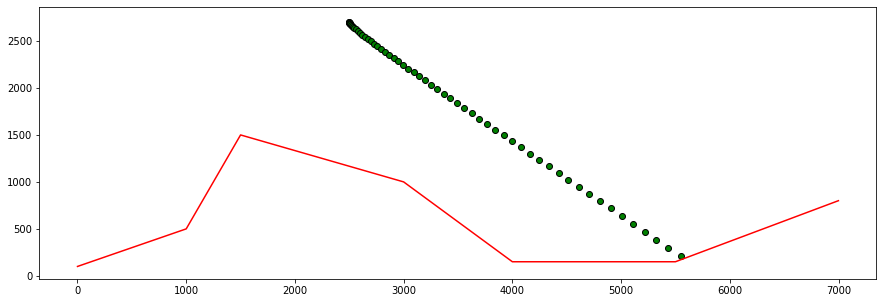

In [490]:
plt.figure(figsize=(15, 5))
plt.plot(SURFACE[:, 0], SURFACE[:, 1], c='red')

for x, y in cords:
    plt.scatter(x, y, edgecolors='black', color='green')

In [491]:
model = ES(eval_f=objective_function, population_size=10, chromosome_len=5, K=0.9)

In [492]:
model.run(iters=1000)

ES(µ + λ): 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 213.23it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.44it/s]


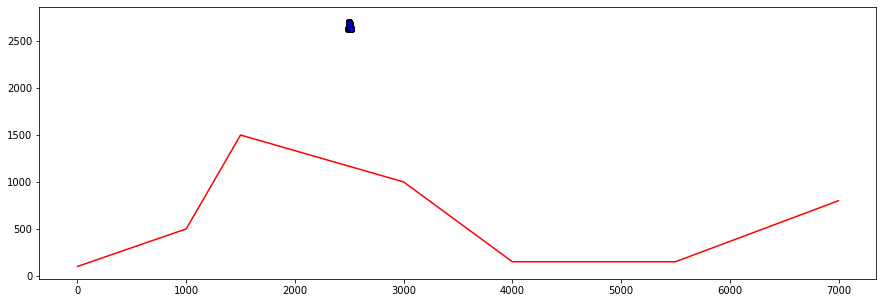

In [493]:
plt.figure(figsize=(15, 5))
plt.plot(SURFACE[:, 0], SURFACE[:, 1], c='red')

for ans in tqdm(model.best_individuals):
    tmp = simmulate(genotype=ans[0], x=2500, y=2700, h_speed=0, v_speed=0, fuel=550, angle=0, power=0)[1]
    for x, y in tmp:
        plt.scatter(x, y, edgecolors='black', color='blue', alpha=0.6)